In [27]:
# import packages
import pandas as pd 
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

from matplotlib.pyplot import figure
matplotlib.rcParams['figure.figsize'] = (12,8)

import plotly.express as px

import plotly.express as px
import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [3]:
data = pd.read_csv('Final_Chicago_Traffic_Crashes_Cleaned.csv') 
display(data.shape)
display(data.info())

# select numeric columns
df_numeric = data.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# select non numeric columns
df_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(517457, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517457 entries, 0 to 517456
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   POSTED_SPEED_LIMIT       517457 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   517457 non-null  object 
 2   DEVICE_CONDITION         517457 non-null  object 
 3   WEATHER_CONDITION        517457 non-null  object 
 4   LIGHTING_CONDITION       517457 non-null  object 
 5   FIRST_CRASH_TYPE         517457 non-null  object 
 6   TRAFFICWAY_TYPE          517457 non-null  object 
 7   ALIGNMENT                517457 non-null  object 
 8   ROADWAY_SURFACE_COND     517457 non-null  object 
 9   ROAD_DEFECT              517457 non-null  object 
 10  REPORT_TYPE              517457 non-null  object 
 11  CRASH_TYPE               517457 non-null  object 
 12  DAMAGE                   517457 non-null  object 
 13  PRIM_CONTRIBUTORY_CAUSE  517457 non-null  object 
 14  SEC_

None

['POSTED_SPEED_LIMIT' 'STREET_NO' 'BEAT_OF_OCCURRENCE' 'NUM_UNITS'
 'CRASH_HOUR' 'CRASH_DAY_OF_WEEK' 'CRASH_MONTH']
['TRAFFIC_CONTROL_DEVICE' 'DEVICE_CONDITION' 'WEATHER_CONDITION'
 'LIGHTING_CONDITION' 'FIRST_CRASH_TYPE' 'TRAFFICWAY_TYPE' 'ALIGNMENT'
 'ROADWAY_SURFACE_COND' 'ROAD_DEFECT' 'REPORT_TYPE' 'CRASH_TYPE' 'DAMAGE'
 'PRIM_CONTRIBUTORY_CAUSE' 'SEC_CONTRIBUTORY_CAUSE' 'STREET_DIRECTION'
 'STREET_NAME' 'LOCATION']


In [4]:
data['CRASH_TYPE'].value_counts(normalize = True)

NO INJURY / DRIVE AWAY              0.750563
INJURY AND / OR TOW DUE TO CRASH    0.249437
Name: CRASH_TYPE, dtype: float64

In [5]:
y = data['CRASH_TYPE']
X = data.drop(['CRASH_TYPE'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [7]:
numeric_features = ['POSTED_SPEED_LIMIT', 'STREET_NO',
                   'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
                   'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
                   'CRASH_MONTH']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                       'WEATHER_CONDITION', 'LIGHTING_CONDITION',
                       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
                       'REPORT_TYPE', 'DAMAGE',
                       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
                       'STREET_DIRECTION', 'STREET_NAME']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

In [8]:
def run_model(model, X_train, X_test, y_train, y_test, classes = None, normalize = 'true', cmap = 'Blues', label = ''):
    
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep = '\n')
    print(classification_report(y_train, y_hat_train))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(20, 10))
    matrices_train = plot_confusion_matrix(model, X_train, y_train, 
                                           labels = classes, normalize = normalize, 
                                           cmap = cmap, ax=axes);
    axes.set(title = 'Confusion Matrix Training')
    
    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep = '\n')
    print((classification_report(y_test, y_hat_test)))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(20, 10))
    matrices_test = plot_confusion_matrix(model, X_test, y_test, 
                                          labels = classes, normalize = normalize, 
                                          cmap = cmap, ax=axes);
    axes.set(title = 'Confusion Matrix Testing')
    
    plt.rcParams.update({'font.size': 15})
  
    return model # return the model object!!!

# Random Forest

In [9]:
forest = RandomForestClassifier()

In [10]:
# Creating Parameters for Grid

params_grid_rf = {'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 10, 15, 20],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10]
                  }

# Creating Grid Search

grid_rf = GridSearchCV(forest, params_grid_rf, verbose = 2, cv = 3)

# Fitting the X_train and y_train to Grid Search

grid_rf.fit(X_train_tf, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=  12.2s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=  12.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=  11.2s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=  12.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=  12.1s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=  10.8s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=  10.9s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=  11.3s

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=  22.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=  22.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=  22.7s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=  22.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=  22.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=  22.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=  22.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=  21.6s
[CV] END criterion=gini, max_depth=10, max_features=au

[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  40.8s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=  39.7s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=  38.0s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=  41.1s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=  41.3s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=  39.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=  42.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=  44.7s
[CV] END criterion=gini, max_depth=15, max_features=s

[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time= 1.0min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time= 1.0min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=  58.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time= 1.0min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=  55.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=  58.2s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=  11.1s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=  11.7s
[CV] END criterion=entropy, max_depth=5, max_feat

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=  20.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=  20.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=  19.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=  19.6s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=  20.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=  18.6s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=  19.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=  19.7s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=  35.6s
[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=  36.7s
[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=  40.3s
[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=  37.7s
[CV] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  44.0s
[CV] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  46.2s
[CV] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  44.7s
[CV] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  42.5s
[CV] END criterion=entropy, m

[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=  56.5s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=  58.3s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time= 1.2min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time= 1.1min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time= 1.1min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time= 1.1min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time= 1.0min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time= 1.2min
[CV] END criterion=entropy, m

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [11]:
# Here is the best combination of parameters

grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
# Running Model Function with Best Parameters of Random Forest Classifier

run_model(grid_rf.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, label = 'HYPER TUNED RANDOM FOREST CLASSIFIER')

In [13]:
feat_names = ['POSTED_SPEED_LIMIT', 'STREET_NO',
              'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
              'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
              'CRASH_MONTH']

for a in preprocessor.transformers_[1][1].categories_:
    feat_names.extend(a.tolist())

In [14]:
len(feat_names)

1666

In [15]:
len(grid_rf.best_estimator_.feature_importances_)

1666

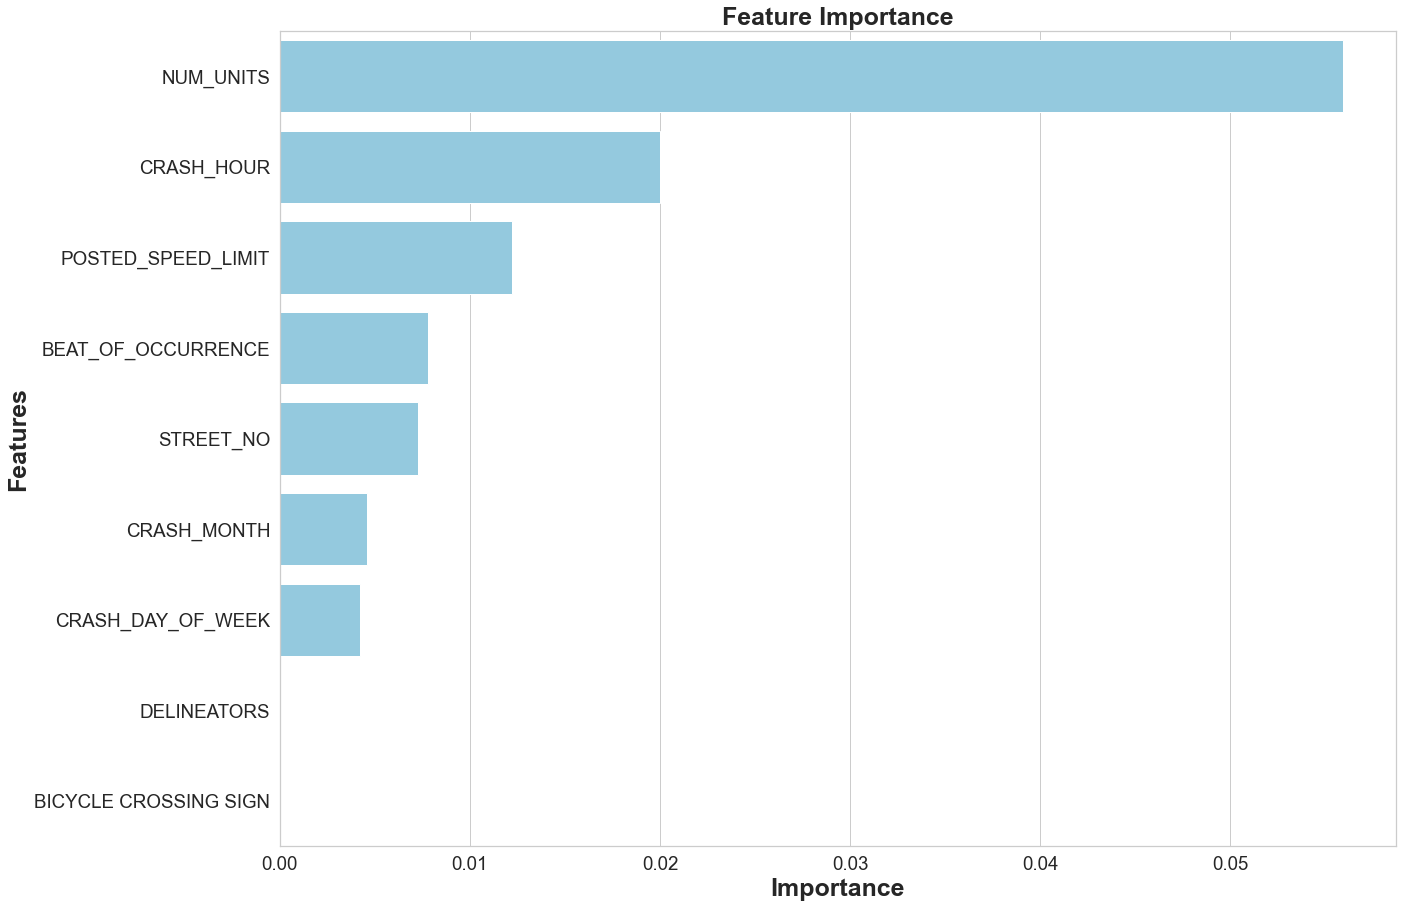

None

,Features,Gini-Importance
0,NUM_UNITS,0.055898
1,CRASH_HOUR,0.020004
2,POSTED_SPEED_LIMIT,0.012198
3,BEAT_OF_OCCURRENCE,0.007815
4,STREET_NO,0.007298
5,CRASH_MONTH,0.004589
6,CRASH_DAY_OF_WEEK,0.004228
7,DELINEATORS,0.000039
8,BICYCLE CROSSING SIGN,0.000015


In [16]:
feats = {}
for feature, importance in zip(feat_names, grid_rf.best_estimator_.feature_importances_[:9]):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,15)

sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance for Hyper Tuned X ', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [ ]:
sns.countplot(data = data, x = "CRASH_TYPE", hue = "NUM_UNITS");

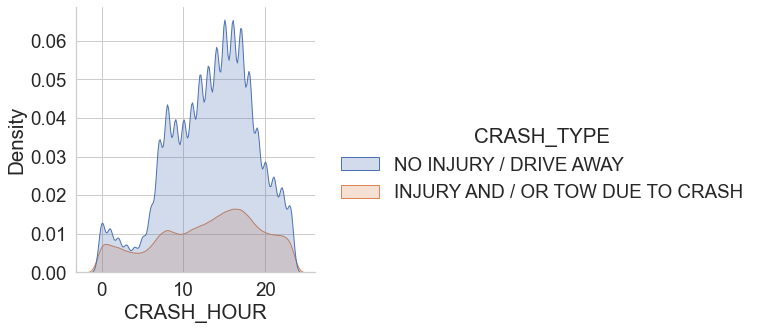

In [17]:
sns.displot(data = data, x = 'CRASH_HOUR', hue = 'CRASH_TYPE', kind = 'kde', fill = True)

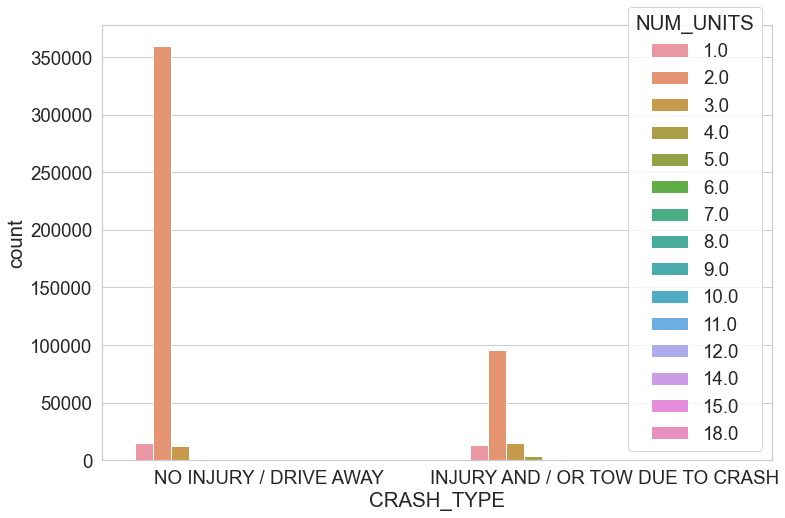

In [18]:
sns.countplot(data = data, x = "CRASH_TYPE", hue = "NUM_UNITS");

# XGB Classifier

In [19]:
# Instantiate XGBClassifier
xgb_clf2 = XGBClassifier()

In [20]:
# Creating Parameters for Grid

param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15, 20],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.1, 0.3, 0.5, 0.7],
    'n_estimators': [100],
}

# Creating Grid Search

grid_xgb = GridSearchCV(xgb_clf2, param_grid_xgb, verbose = 2, cv = 3)

# Fitting the X_train and y_train to Grid Search

grid_xgb.fit(X_train_tf, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[20:00:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.1; total time=  11.4s
[20:00:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.1; total 

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.3; total time=  15.5s
[20:05:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  18.7s
[20:05:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=5, min_chil

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.7; total time=  19.8s
[20:10:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.1; total time=  22.4s
[20:10:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=10, min_ch

[20:19:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.3; total time=  29.9s
[20:19:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  35.4s
[20:20:30] WARNING: /opt/concourse/worker/volume

[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.7; total time=  36.8s
[20:29:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.7; total time=  37.9s
[20:30:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=15, min_c

[20:42:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=15, min_child_weight=2, n_estimators=100, subsample=0.3; total time=  48.4s
[20:43:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=15, min_child_weight=2, n_estimators=100, subsample=0.3; total time=  46.5s
[20:44:15] WARNING: /opt/concourse/worker/volume

[CV] END learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=100, subsample=0.7; total time= 1.1min
[20:59:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=100, subsample=0.7; total time= 1.2min
[21:00:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=15, min_c

[21:20:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=100, subsample=0.3; total time= 1.2min
[21:21:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=100, subsample=0.3; total time= 1.1min
[21:22:30] WARNING: /opt/concourse/worker/volume

[CV] END learning_rate=0.01, max_depth=20, min_child_weight=3, n_estimators=100, subsample=0.5; total time= 1.4min
[21:43:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=3, n_estimators=100, subsample=0.7; total time= 1.6min
[21:44:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=20, min_c

[21:51:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.1; total time=  10.7s
[21:51:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.3; total time=  13.7s
[21:51:28] WARNING: /opt/concourse/worker/volumes/

[CV] END learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  16.2s
[21:55:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  16.3s
[21:55:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, min_chil

[22:02:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.1; total time=  20.6s
[22:03:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.1; total time=  20.5s
[22:03:37] WARNING: /opt/concourse/worker/volume

[CV] END learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  36.9s
[22:12:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  38.3s
[22:12:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=10, min_c

[22:25:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=2, n_estimators=100, subsample=0.1; total time=  31.9s
[22:25:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=2, n_estimators=100, subsample=0.1; total time=  31.9s
[22:26:27] WARNING: /opt/concourse/worker/volume

[CV] END learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  39.2s
[22:38:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  50.8s
[22:39:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, min_c

[22:54:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=20, min_child_weight=1, n_estimators=100, subsample=0.7; total time= 1.2min
[22:55:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=20, min_child_weight=2, n_estimators=100, subsample=0.1; total time=  35.2s
[22:55:56] WARNING: /opt/concourse/worker/volume

[CV] END learning_rate=0.05, max_depth=20, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  49.4s
[23:09:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=20, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  49.6s
[23:10:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=20, min_c

[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  17.8s
[23:20:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  17.5s
[23:20:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=5, min_child_w

[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  14.4s
[23:24:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  14.8s
[23:24:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=5, min_child_w

[CV] END learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  35.0s
[23:31:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  34.5s
[23:32:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=10, min_chil

[CV] END learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  25.5s
[23:40:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  25.0s
[23:40:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=10, min_chil

[CV] END learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  48.7s
[23:50:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  48.8s
[23:51:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=15, min_chil

[CV] END learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  36.4s
[00:01:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  36.9s
[00:02:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=15, min_chil

[CV] END learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=100, subsample=0.7; total time= 1.1min
[00:16:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=100, subsample=0.7; total time= 1.1min
[00:18:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=20, min_chil

[CV] END learning_rate=0.1, max_depth=20, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  48.8s
[00:31:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=20, min_child_weight=3, n_estimators=100, subsample=0.3; total time=  48.9s
[00:32:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=20, min_chil

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [21]:
# Here is the best combination of parameters

grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.7}

[00:39:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------------------------
XGB CLASSIFIER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.73      0.66      0.69     90410
          NO INJURY / DRIVE AWAY       0.89      0.92      0.90    271809

                        accuracy                           0.85    362219
                       macro avg       0.81      0.79      0.80    362219
                    weighted avg       0.85      0.85      0.85    362219

-----------------------

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

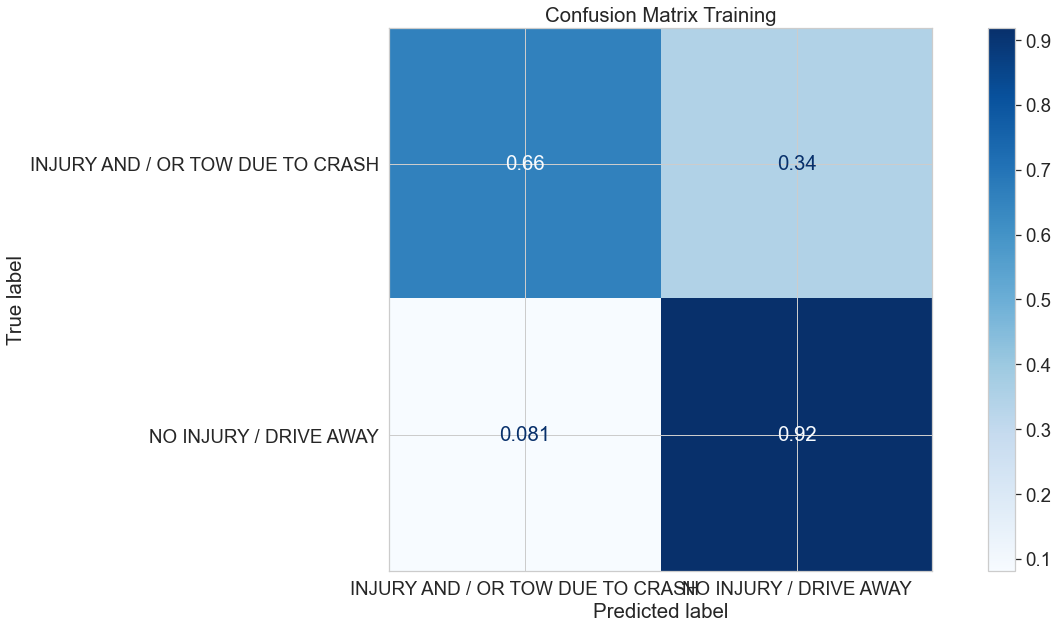

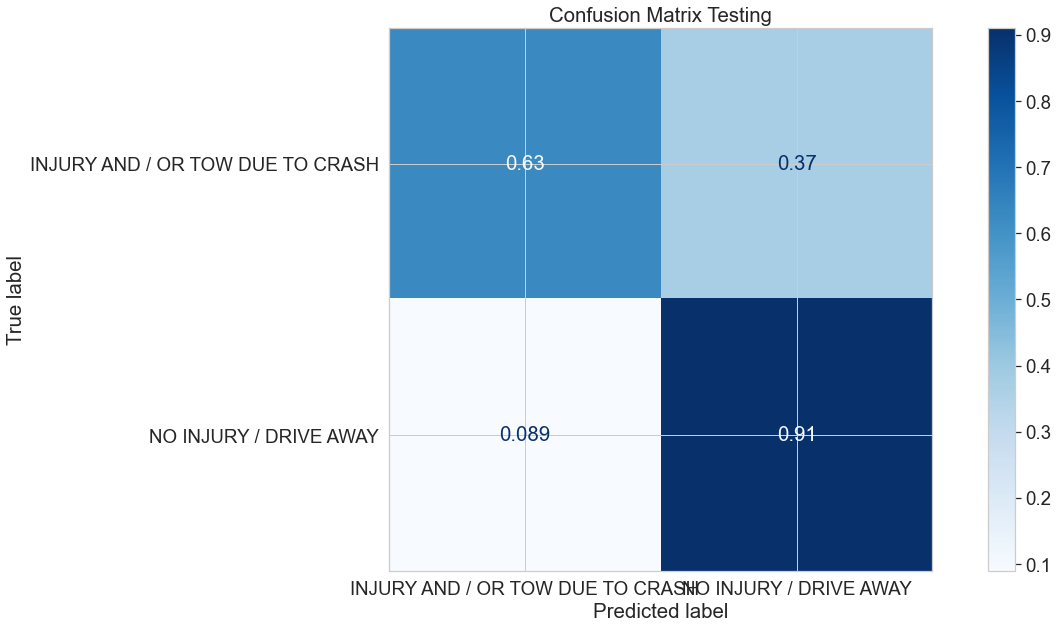

In [22]:
# Running Model Function with Best Parameters of XGB Classifier

run_model(grid_xgb.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, label = 'XGB CLASSIFIER')

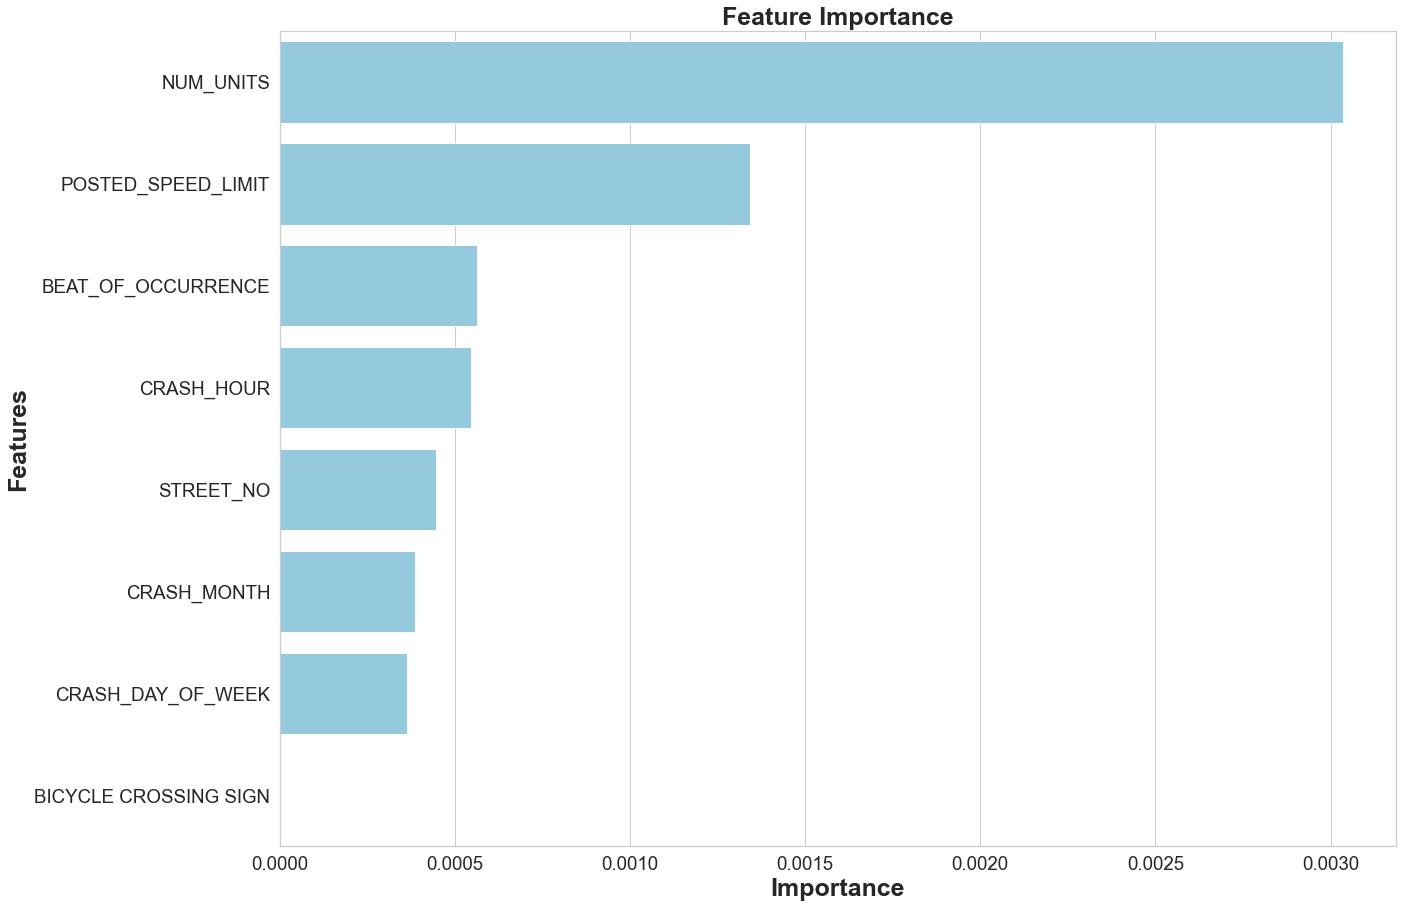

None

,Features,Gini-Importance
0,NUM_UNITS,0.003034
1,POSTED_SPEED_LIMIT,0.001342
2,BEAT_OF_OCCURRENCE,0.000562
3,CRASH_HOUR,0.000548
4,STREET_NO,0.000446
5,CRASH_MONTH,0.000385
6,CRASH_DAY_OF_WEEK,0.000362
7,BICYCLE CROSSING SIGN,0.000000


In [23]:
feats = {}
for feature, importance in zip(feat_names, grid_xgb.best_estimator_.feature_importances_[:8]):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,15)

sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)